# Beast cancer classification with Machine Learning

Breast cancer is a critical health concern affecting a significant number of individuals worldwide. Early and accurate detection of breast cancer plays a vital role in improving patient outcomes and reducing mortality rates.

In this project, **our goal is to develop a predictive model that can classify breast tumors as malignant (cancerous) or benign (non-cancerous)** using the breast cancer dataset from scikit-learn.

By leveraging <span style="font-size: 11pt; color: rgb(144, 200, 144); font-weight: normal">**machine learning techniques**</span>, we aim to create a model that can effectively analyze various features extracted from breast cancer samples, such as the tumor size, texture, and other relevant factors. This <u>model will learn from a labeled dataset</u> of breast cancer samples and their corresponding diagnosis, enabling it to make accurate predictions on new, unseen data.

The significance of this project lies in its <span style="font-size: 11pt; color: rgb(144, 200, 144); font-weight: normal">**potential to assist medical professionals in diagnosing breast cancer more efficiently**</span>. By providing a <u>reliable tool for automated classification</u>, this model can aid in the early identification of malignant tumors, enabling timely interventions and improved patient care.

Throughout this project, we will implement a **Neural Network** architecture, specifically a **multilayer perceptron**, to train and evaluate the model's performance. By optimizing the network's parameters and leveraging appropriate activation functions, we aim to achieve high accuracy and F1 score to minimize false positive and false negative predictions.

This project serves as a <u>practical application of machine learning in the field of healthcare</u>, showcasing the potential to leverage advanced algorithms to enhance breast cancer diagnosis.

## Importing libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

## Preparing Data

In [2]:
# Load data
cancer = load_breast_cancer()

# Get features and target
X = cancer.data
Y = cancer.target

# Get feature names
feature_names = cancer.feature_names
feature_names = list(feature_names)
feature_names.append('target')

# Construct DataFrame
XY = np.column_stack((X,Y))
df = pd.DataFrame(XY, columns=feature_names)

# DataFrame
df.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [3]:
# Split data into train and test datasets
x = df.drop('target', axis=1)
y = df.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42, stratify=y)

# Check shapes after splitting the data
display(
    x_train.shape,
    y_train.shape,
    x_test.shape,
    y_test.shape
)

(483, 30)

(483,)

(86, 30)

(86,)

## Normalizing data:
To apply ```StandardScaler``` correctly and avoid data leakage, we should fit the scaler on the training data and then use the trained scaler to transform **both** the training and testing:

In [4]:
# Creat StandardScaler object
scaler = StandardScaler()

# Fit scaler on the training data
scaler.fit(x_train)

# Transform train data
x_train = scaler.transform(x_train)

# Transform test data using the same fitted scaler object
x_test = scaler.transform(x_test)

## Adjust Data shapes before feeding into NN

In [5]:
x_train = np.array(x_train).T
y_train = np.array(y_train).reshape(1, -1)
x_test = np.array(x_test).T
y_test = np.array(y_test).reshape(1, -1)

In [6]:
# Check shapes after splitting the data
display(
    x_train.shape,
    y_train.shape,
    x_test.shape,
    y_test.shape
)

(30, 483)

(1, 483)

(30, 86)

(1, 86)

## Create Neural Network class

In [7]:
class NeuralNetwork:
    def __init__(self, n_h1, n_h2, num_iterations=10000, learning_rate=0.03):
        """
        Initialize the NeuralNetwork object.
        
        Arguments:
        n_h1 -- size of the first hidden layer
        n_h2 -- size of the second hidden layer
        num_iterations -- number of iterations in the gradient descent loop
        learning_rate -- learning rate for gradient descent
        """
        self.n_h1 = n_h1
        self.n_h2 = n_h2
        self.num_iterations = num_iterations
        self.learning_rate = learning_rate
        self.parameters = None
        self.costs = []
        self.acc_train = []

    def fit(self, X, Y, print_cost=False):
        """
        Train the neural network model on the given training data.
        
        Arguments:
        X -- input data of shape (n_x, m)
        Y -- labels of shape (1, m)
        print_cost -- if True, print the cost every 1000 iterations
        """
        np.random.seed(3)
        n_x = X.shape[0]
        n_y = Y.shape[0]
        layer_dims = [n_x, self.n_h1, self.n_h2, n_y]
        self.costs = [float('inf')]
        self.acc_train = []

        self.parameters = self.initialize_parameters(layer_dims)

        for i in range(self.num_iterations):
            A3, cache = self.forward_propagation(X)
            cost = self.compute_cost(A3, Y)

            grads = self.backward_propagation(cache, X, Y)
            self.parameters = self.update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("Cost after iteration %i: %f" %(i, cost))

            pred_train = self.predict(X)
            self.acc_train.append(accuracy_score(Y.reshape(-1), pred_train.reshape(-1)))
            self.costs.append(cost)

    def predict(self, X):
        """
        Perform prediction using the trained model.
        
        Arguments:
        X -- input data of shape (n_x, m)
        
        Returns:
        predictions -- vector of predictions of the model
        """
        A3, _ = self.forward_propagation(X)
        condition = A3 > 0.5
        predictions = np.where(condition, 1, 0)
        return predictions

    def initialize_parameters(self, layer_dims):
        """
        Initialize the parameters of the neural network.
        
        Arguments:
        layer_dims -- list containing the dimensions of each layer, including the input layer
        
        Returns:
        parameters -- dictionary containing the initialized parameters
        """
        parameters = {}
        L = len(layer_dims)

        for l in range(1, L):
            parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.001
            parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        return parameters

    def forward_propagation(self, X):
        """
        Perform forward propagation to compute the outputs of each layer.
        
        Arguments:
        X -- input data of shape (n_x, m)
        
        Returns:
        A3 -- the output of the third activation
        cache -- dictionary containing the intermediate values
        """
        parameters = self.parameters

        W1 = parameters['W1']
        b1 = parameters['b1']
        W2 = parameters['W2']
        b2 = parameters['b2']
        W3 = parameters['W3']
        b3 = parameters['b3']

        Z1 = W1 @ X + b1
        A1 = self.leaky_relu(Z1)
        Z2 = W2 @ A1 + b2
        A2 = self.leaky_relu(Z2)
        Z3 = W3 @ A2 + b3
        A3 = self.sigmoid(Z3)

        cache = {
            "Z1": Z1,
            "A1": A1,
            "Z2": Z2,
            "A2": A2,
            "Z3": Z3,
            "A3": A3
        }

        return A3, cache

    def backward_propagation(self, cache, X, Y):
        """
        Perform backward propagation to compute the gradients.
        
        Arguments:
        cache -- dictionary containing the intermediate values
        X -- input data of shape (n_x, m)
        Y -- labels of shape (1, m)
        
        Returns:
        grads -- dictionary containing the gradients with respect to different parameters
        """
        m = X.shape[1]
        parameters = self.parameters

        W1 = parameters['W1']
        W2 = parameters['W2']
        W3 = parameters['W3']

        A1 = cache['A1']
        A2 = cache['A2']
        A3 = cache['A3']

        dZ3 = A3 - Y
        dW3 = (dZ3 @ A2.T) / m
        db3 = np.sum(dZ3, axis=1, keepdims=True) / m

        dZ2 = W3.T @ dZ3 * self.leaky_relu_derivative(A2)
        dW2 = (dZ2 @ A1.T) / m
        db2 = np.sum(dZ2, axis=1, keepdims=True) / m

        dZ1 = W2.T @ dZ2 * self.leaky_relu_derivative(A1)
        dW1 = (dZ1 @ X.T) / m
        db1 = np.sum(dZ1, axis=1, keepdims=True) / m

        grads = {
            "dW1": dW1,
            "db1": db1,
            "dW2": dW2,
            "db2": db2,
            "dW3": dW3,
            "db3": db3
        }

        return grads

    def update_parameters(self, grads):
        """
        Update the parameters using gradient descent.
        
        Arguments:
        grads -- dictionary containing the gradients
        
        Returns:
        parameters -- dictionary containing the updated parameters
        """
        parameters = self.parameters

        dW1 = grads['dW1']
        db1 = grads['db1']
        dW2 = grads['dW2']
        db2 = grads['db2']
        dW3 = grads['dW3']
        db3 = grads['db3']

        parameters['W1'] -= self.learning_rate * dW1
        parameters['b1'] -= self.learning_rate * db1
        parameters['W2'] -= self.learning_rate * dW2
        parameters['b2'] -= self.learning_rate * db2
        parameters['W3'] -= self.learning_rate * dW3
        parameters['b3'] -= self.learning_rate * db3

        return parameters

    def leaky_relu(self, Z):
        """
        Apply the Leaky ReLU activation function.
        
        Arguments:
        Z -- input of any shape
        
        Returns:
        A -- output of the activation function
        """
        return np.maximum(0.01 * Z, Z)

    def leaky_relu_derivative(self, Z):
        """
        Compute the derivative of the Leaky ReLU activation function.
        
        Arguments:
        Z -- input of any shape
        
        Returns:
        dA -- derivative of the activation function
        """
        return np.where(Z > 0, 1, 0.01)

    def sigmoid(self, Z):
        """
        Apply the sigmoid activation function.
        
        Arguments:
        Z -- input of any shape
        
        Returns:
        A -- output of the activation function
        """
        return 1 / (1 + np.exp(-Z))

    def compute_cost(self, A2, Y):
        """
        Compute the cross-entropy cost given the predicted probabilities A2 and the true labels Y.
        
        Arguments:
        A2 -- the sigmoid output of the second activation, of shape (1, number of examples)
        Y -- "true" labels vector of shape (1, number of examples)
        
        Returns:
        cost -- cross-entropy cost
        """
        m = Y.shape[1]
        epsilon = 1e-8
        logprobs = np.multiply(Y, np.log(A2 + epsilon)) + np.multiply(1 - Y, np.log(1 - A2 + epsilon))
        cost = -np.sum(logprobs) / m
        cost = np.squeeze(cost)
        return cost


### Initialize the model and fit it on the training data

In [8]:
n_h1 = 36
n_h2 = 18
num_iterations = 100_000
learning_rate = 0.03

model = NeuralNetwork(n_h1=n_h1, n_h2=n_h2,
                      num_iterations=num_iterations, 
                      learning_rate=learning_rate)

model.fit(x_train, y_train, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 1000: 0.660362
Cost after iteration 2000: 0.660362
Cost after iteration 3000: 0.660362
Cost after iteration 4000: 0.660362
Cost after iteration 5000: 0.660361
Cost after iteration 6000: 0.660361
Cost after iteration 7000: 0.660360
Cost after iteration 8000: 0.660356
Cost after iteration 9000: 0.660318
Cost after iteration 10000: 0.639298
Cost after iteration 11000: 0.050632
Cost after iteration 12000: 0.035480
Cost after iteration 13000: 0.023640
Cost after iteration 14000: 0.015621
Cost after iteration 15000: 0.010617
Cost after iteration 16000: 0.007442
Cost after iteration 17000: 0.005460
Cost after iteration 18000: 0.004144
Cost after iteration 19000: 0.003237
Cost after iteration 20000: 0.002584
Cost after iteration 21000: 0.002108
Cost after iteration 22000: 0.001751
Cost after iteration 23000: 0.001481
Cost after iteration 24000: 0.001270
Cost after iteration 25000: 0.001104
Cost after iteration 26000: 0.000971
Cost after ite

### Get model's predictions and compute accuracy and F1 score

In [9]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)

print (f'Accuracy score on train data: {accuracy_score(y_train.reshape(-1), pred_train.reshape(-1))}')
print (f'Accuracy score on test data: {accuracy_score(y_test.reshape(-1), pred_test.reshape(-1))}\n')

print (f'F1 score on train data: {f1_score(y_train.reshape(-1), pred_train.reshape(-1))}')
print (f'F1 score test data: {f1_score(y_test.reshape(-1), pred_test.reshape(-1))}')

Accuracy score on train data: 1.0
Accuracy score on test data: 0.9534883720930233

F1 score on train data: 1.0
F1 score test data: 0.9622641509433962


### Plot Accuracy and Costs during training

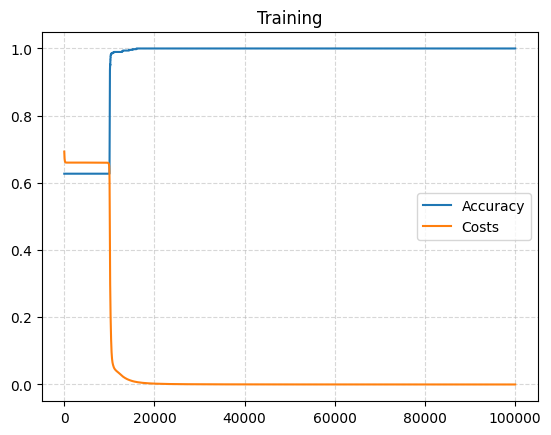

In [10]:
plt.plot(np.arange(0,len(model.acc_train),1), model.acc_train, label='Accuracy')
plt.plot(np.arange(0,len(model.costs),1), model.costs, label='Costs')

plt.title('Training')
plt.grid(True, ls='dashed', alpha=0.5)
plt.legend()

plt.show;

## Conclusion

In this project, a neural network model was trained to predict whether breast cancer is malignant or not using the breast cancer dataset from the sklearn library. The model was implemented as a multilayer perceptron (MLP) with two hidden layers.

After training the model, it achieved a perfect accuracy score of 1.0 on the training data, indicating that it was able to correctly classify all instances in the training set. On the test data, the model achieved an accuracy score of 0.953, demonstrating its ability to generalize well to unseen data.

Additionally, the model obtained **high F1 scores** of **1.0** on the training data and **0.962** on the test data. The F1 score considers both precision and recall, <span style="font-size: 11pt; color: rgb(144, 200, 144); font-weight: normal">**providing a balanced measure of the model's performance**</span>.

These results indicate that the neural network model trained on the breast cancer dataset is highly accurate and capable of effectively distinguishing between malignant and benign breast cancer cases. The model shows promise for assisting in the early detection and diagnosis of breast cancer, potentially improving patient outcomes.

Further improvements could involve <u>fine-tuning the model's hyperparameters or exploring other neural network architectures</u> to potentially enhance its performance even further.